# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

**Признаки**

* DateCrawled — дата скачивания анкеты из базы
* VehicleType — тип автомобильного кузова
* RegistrationYear — год регистрации автомобиля
* Gearbox — тип коробки передач
* Power — мощность (л. с.)
* Model — модель автомобиля
* Kilometer — пробег (км)
* RegistrationMonth — месяц регистрации автомобиля
* FuelType — тип топлива
* Brand — марка автомобиля
* Repaired — была машина в ремонте или нет
* DateCreated — дата создания анкеты
* NumberOfPictures — количество фотографий автомобиля
* PostalCode — почтовый индекс владельца анкеты (пользователя)
* LastSeen — дата последней активности пользователя

**Целевой признак**

* Price — цена (евро)

## Подготовка данных

In [1]:
import os
import time

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.metrics

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error as mse

from lightgbm import LGBMRegressor
import lightgbm as lgb

In [2]:
df = pd.read_csv('autos.csv')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [3]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Price,354369.0,4416.656776,4514.158514,0.0,1050.0,2700.0,6400.0,20000.0
RegistrationYear,354369.0,2004.234448,90.227958,1000.0,1999.0,2003.0,2008.0,9999.0
Power,354369.0,110.094337,189.850405,0.0,69.0,105.0,143.0,20000.0
Kilometer,354369.0,128211.172535,37905.341530,5000.0,125000.0,150000.0,150000.0,150000.0
RegistrationMonth,354369.0,5.714645,3.726421,0.0,3.0,6.0,9.0,12.0
NumberOfPictures,354369.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
PostalCode,354369.0,50508.689087,25783.096248,1067.0,30165.0,49413.0,71083.0,99998.0


In [4]:
df_orig_shape = df.shape

Удалим колонки, которые не влияют на цену автомобиля ```DateCrawled, DateCreated, LastSeen, NumberOfPictures```, последнию удаляем так как признак содержит только одно значение "0"

In [6]:
df = df.drop(columns=['DateCrawled', 'LastSeen', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'RegistrationMonth'])
df.shape

(354369, 10)

Удалим явные дубликаты

In [7]:
df = df.drop_duplicates()
df.shape

(309329, 10)

Разделим признаки на категориальные и количественные 

In [8]:
numerical_features = ['Power', 'Kilometer', 'RegistrationYear']
categorial_features = ['VehicleType', 'Gearbox', 'Model', 'FuelType',
                       'Brand', 'Repaired']

Определим количество пропусков в данных

In [9]:
for index in df.columns:
    print('Столбец {} содержит {} пропусков - это {:.2%} от общего числа'.format(index, df[index].isna().sum(), df[index].isna().sum()/df.shape[0]))

Столбец Price содержит 0 пропусков - это 0.00% от общего числа
Столбец VehicleType содержит 34559 пропусков - это 11.17% от общего числа
Столбец RegistrationYear содержит 0 пропусков - это 0.00% от общего числа
Столбец Gearbox содержит 17207 пропусков - это 5.56% от общего числа
Столбец Power содержит 0 пропусков - это 0.00% от общего числа
Столбец Model содержит 18361 пропусков - это 5.94% от общего числа
Столбец Kilometer содержит 0 пропусков - это 0.00% от общего числа
Столбец FuelType содержит 30764 пропусков - это 9.95% от общего числа
Столбец Brand содержит 0 пропусков - это 0.00% от общего числа
Столбец Repaired содержит 64558 пропусков - это 20.87% от общего числа


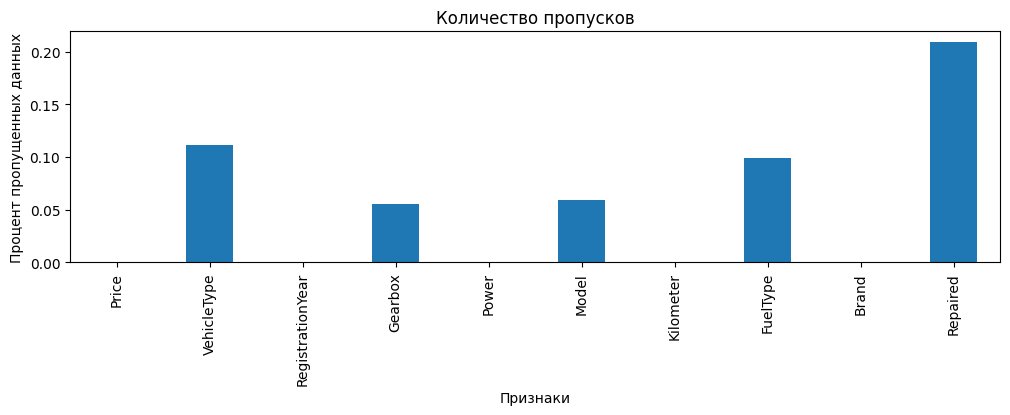

In [10]:
df.isna().mean().plot.bar(figsize=(12, 3))
plt.ylabel('Процент пропущенных данных')
plt.xlabel('Признаки')
plt.title('Количество пропусков')
plt.show()

Оценим количество уникальных знначений в категориальных признаках

Признак ```RegistrationYear```

In [11]:
print(np.sort(df['RegistrationYear'].unique()))

[1000 1001 1039 1111 1200 1234 1253 1255 1300 1400 1500 1600 1602 1688
 1800 1910 1915 1919 1920 1923 1925 1927 1928 1929 1930 1931 1932 1933
 1934 1935 1936 1937 1938 1940 1941 1942 1943 1944 1945 1946 1947 1948
 1949 1950 1951 1952 1953 1954 1955 1956 1957 1958 1959 1960 1961 1962
 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974 1975 1976
 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990
 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004
 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018
 2019 2066 2200 2222 2290 2500 2800 2900 3000 3200 3500 3700 3800 4000
 4100 4500 4800 5000 5300 5555 5600 5900 5911 6000 6500 7000 7100 7500
 7800 8000 8200 8455 8500 8888 9000 9229 9450 9996 9999]


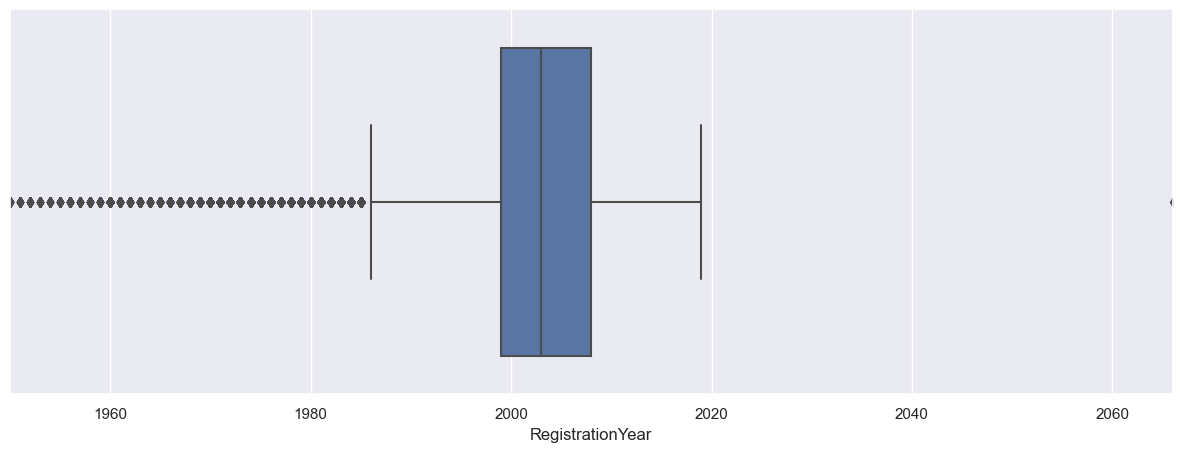

In [12]:
sns.set(rc={'figure.figsize':(15, 5)})
fig, ax = plt.subplots()
sns.boxplot(data=df, x='RegistrationYear', ax=ax)
ax.set_xlim(1950, 2066)
plt.show()

In [13]:
df = df.loc[(df['RegistrationYear'] <= 2016) & (df['RegistrationYear'] > 1985)]
df.shape

(280827, 10)

Признак ```Power```

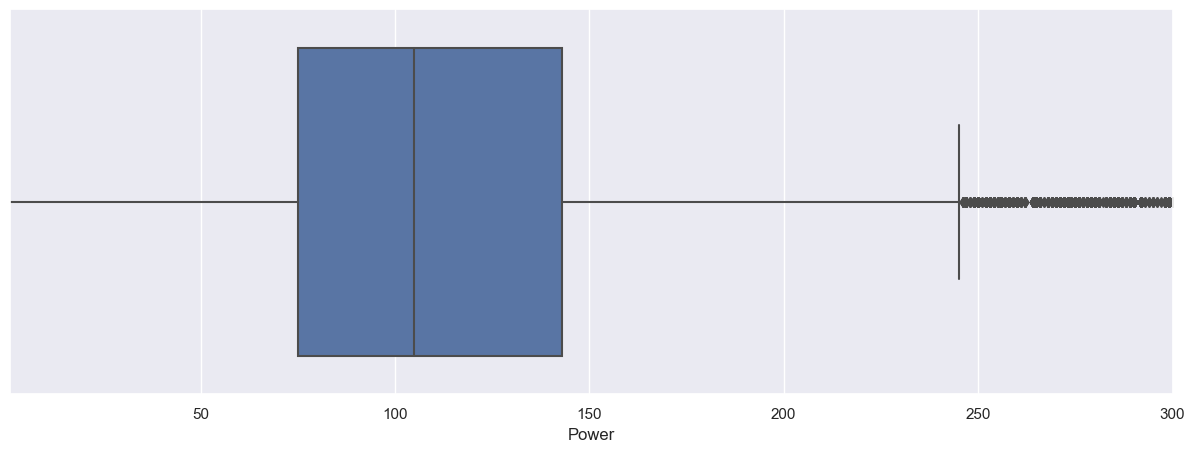

In [14]:
fig, ax = plt.subplots()
sns.boxplot(data=df, x='Power', ax=ax)
ax.set_xlim(1, 300)
plt.show()

In [15]:
df = df.loc[(df['Power'] < 300) & (df['Power'] > 30)]
df.shape

(249068, 10)

Рассмотрим признак ```Kilometer```

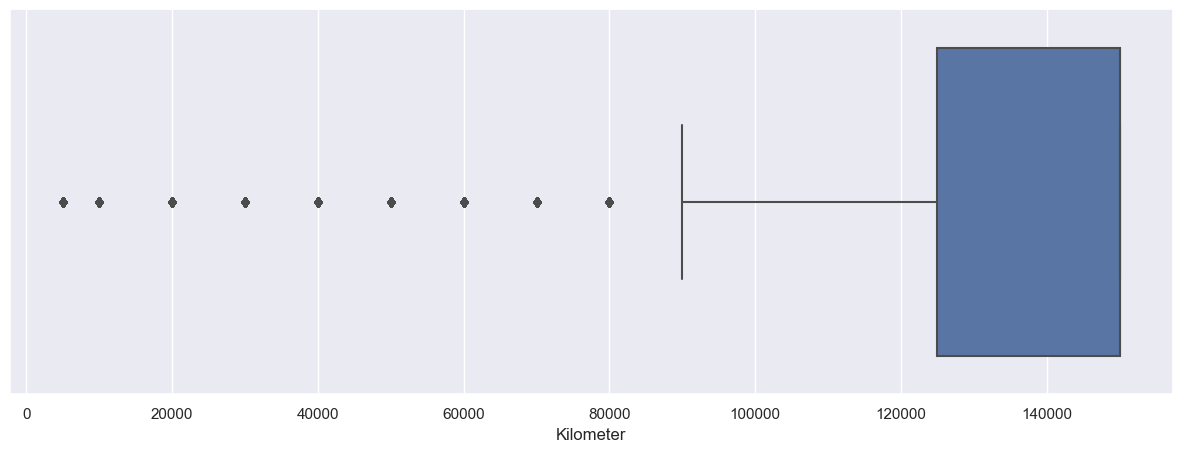

In [16]:
sns.boxplot(data=df, x='Kilometer')
plt.show()

In [17]:
df = df.loc[(df['Kilometer'] > 85000)]
df.shape

(210178, 10)

Признак ```Price```

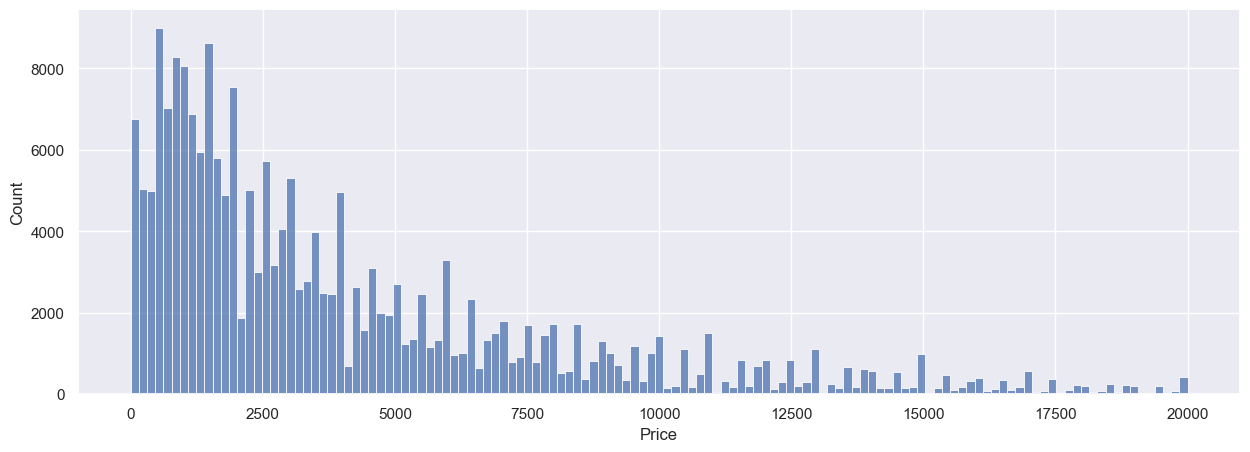

In [18]:
sns.set(rc={'figure.figsize':(15, 5)})
sns.histplot(data=df, x='Price')
plt.show()

<AxesSubplot: xlabel='Price'>

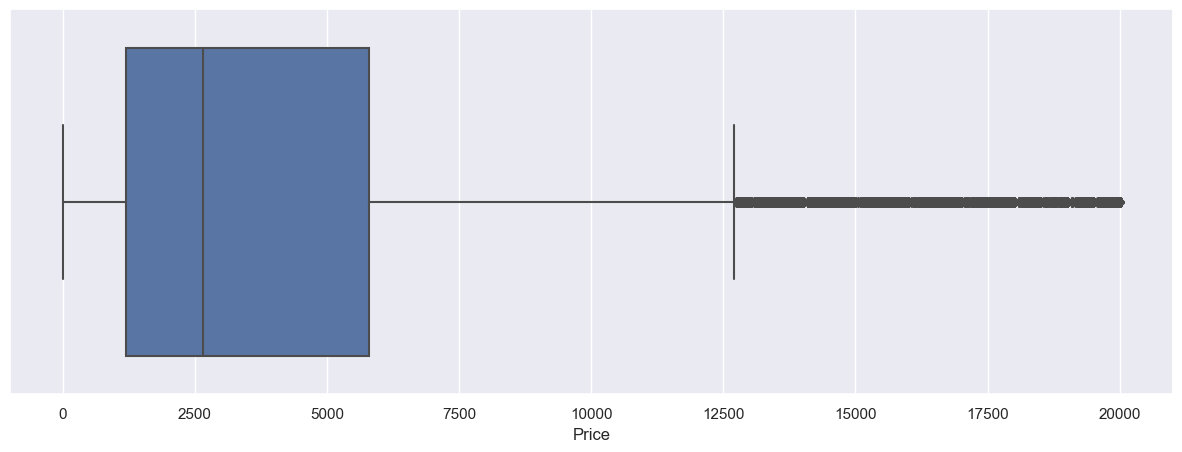

In [19]:
sns.boxplot(data=df, x='Price')

Нулевая цена это явная ошибка заполнения данных, удалим эти объявления из данных.

In [20]:
df = df.loc[(df['Price'] != 0) | (df['Price'] < 15000)]
df.shape

(210178, 10)

Признак ```Model```

Пропуски в этом признаки заполнить не получится, так что удалим эти строки

In [21]:
df['Model'].isna().sum()

8410

In [22]:
df = df[~df['Model'].isna()]

Признак ```Brand```

Пропусков в этом признаке нету

In [23]:
df['Brand'].isna().sum()

0

Признаки ```VehicleType, Gearbox, FuelType```

Пропуски в признаках заполним модой значений с схожими признаками ```Brand, Model```

In [24]:
df['VehicleType'] = df['VehicleType'].fillna(df.groupby('Model')['VehicleType'].transform(lambda x: x.value_counts().idxmax()))

In [25]:
df['Gearbox'] = df['Gearbox'].fillna(df.groupby('Model')['VehicleType'].transform(lambda x: x.value_counts().idxmax()))

In [26]:
df['FuelType'] = df['FuelType'].fillna(df.groupby('Model')['VehicleType'].transform(lambda x: x.value_counts().idxmax()))

In [27]:
print('Процент предобработанных данных к исходным - {:.2%}'.format(df.dropna(axis=0).shape[0]/df_orig_shape[0]))

Процент предобработанных данных к исходным - 48.21%


In [28]:
df.dropna(axis=0).shape[0]

170850

## Обучение моделей

Разделим данные на тренировочную и тестовую выборки

In [29]:
features = df.drop(['Price'], axis = 1)  
target = df['Price'] 

features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.2, random_state=123)

Создадим функцию сбора данных о времени обучения и предсказания моделей

In [30]:
results = []

def time_score(model, model_name, f_train, t_train):
    
    start_time = time.time()
    model.fit(f_train, t_train)
    fit_time = time.time() - start_time
    
    start_time = time.time()
    pred_train = model.predict(f_train)
    pred_time = time.time() - start_time
    
    return model_name, fit_time, pred_time, mse(pred_train, t_train)**0.5

### Ridge

Создадим пайплайн:
* Кодирование OneHotEncoder
* масштабирование StandardScaler
* Обучения алгоритма Ridge

In [31]:
pipe = Pipeline([
    ('ohe', OneHotEncoder(handle_unknown='ignore')),
    ('scaler', StandardScaler(with_mean=False)),
    ('model', Ridge(random_state=12345))
])

params = [
    {
        'model__alpha': np.arange(1, 40, 10)
    } 
]

In [32]:
grid = GridSearchCV(pipe,
                    param_grid=params,
                    cv=3,
                    scoring='neg_mean_squared_error',
                    n_jobs=-1,
                    verbose=False)

In [33]:
grid.fit(features_train, target_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('ohe',
                                        OneHotEncoder(handle_unknown='ignore')),
                                       ('scaler',
                                        StandardScaler(with_mean=False)),
                                       ('model', Ridge(random_state=12345))]),
             n_jobs=-1, param_grid=[{'model__alpha': array([ 1, 11, 21, 31])}],
             scoring='neg_mean_squared_error', verbose=False)

Результаты сохраним в список

In [34]:
results.append(time_score(grid.best_estimator_, 'Ridge', features_train, target_train))

Изменим тип категориальных данных  на ```Category```

In [35]:
features_train[categorial_features] = features_train[categorial_features].astype('category')
features_test[categorial_features] = features_test[categorial_features].astype('category')

Используем ```LabelEncoder``` в качестве метода кодирования категориальных данных, так как новых признаков не появиться и для алгоритма решающего дерева не страшны возможные корреляции закодированных признаков

In [36]:
label_encoder = LabelEncoder()

In [37]:
for col in categorial_features:
    features_train[col] = label_encoder.fit_transform(features_train[col])
    features_test[col] = label_encoder.fit_transform(features_test[col])
    
display(features_train[categorial_features])

,VehicleType,Gearbox,Model,FuelType,Brand,Repaired
209964,6,4,214,5,37,2
304108,1,4,8,9,25,0
119503,7,4,168,5,37,0
23714,1,4,203,9,20,0
38263,5,4,126,9,10,0
...,...,...,...,...,...,...
198872,7,4,152,9,10,2
336011,2,4,11,9,2,0
27202,7,0,28,9,1,0
43412,2,4,213,9,24,1


Отмасштабируем данные

In [38]:
scaler = StandardScaler()

In [39]:
scaler.fit(features_train)

columns = features_train.columns
features_train = pd.DataFrame(scaler.transform(features_train), columns = columns)
features_test = pd.DataFrame(scaler.transform(features_test), columns = columns)

Найдем лучшую модель LGBM и сохраним результаты 

In [40]:
gbm = lgb.LGBMRegressor()

params = {
    'learning_rate': [0.1, 0.7, 1],
    'n_estimators': [40, 60],
    'num_leaves': [21, 31, 41],
}

grid_gbm = GridSearchCV(gbm,
                        params,
                        cv=3,
                        scoring='neg_root_mean_squared_error',
                        verbose=0,
                        n_jobs = -1)

In [41]:
grid_gbm.fit(features_train, target_train)

GridSearchCV(cv=3, estimator=LGBMRegressor(), n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.7, 1],
                         'n_estimators': [40, 60], 'num_leaves': [21, 31, 41]},
             scoring='neg_root_mean_squared_error')

In [42]:
results.append(time_score(grid_gbm.best_estimator_, 'LGBM', features_train, target_train))

## Анализ моделей

Рассмотрим финальные результаты 

In [43]:
results_df = pd.DataFrame(data=results, columns=['Model', 'Fit_time', 'Pred_time', 'RMSE'])

display(results_df)

,Model,Fit_time,Pred_time,RMSE
0,Ridge,1.847322,0.336642,1791.87833
1,LGBM,0.404585,0.152844,1460.32444


## Тестирование лучшей модели

По полученным результатам видно, что алгоритм ```LGBM``` показал лучшее время и метрику ```RMSE```, чем ```Ridge```. Проверим на тестовой выборке:

In [44]:
print(mse(grid_gbm.best_estimator_.predict(features_test), target_test)**0.5)

1648.2523191604234


Финальное значение метрики ```RMSE``` составило 1648, что означает, что данная модель выполняет условия проекта.